# Title :- Implementing Rerankers: Concepts and Code Examples

# Lets Understand Re-Ranking
- Reranking in Retrieval-Augmented Generation (RAG) refers to the process of reordering or refining a set of initially retrieved documents based on their relevance to a user’s query. This step is crucial for optimizing the quality of the information that the LLM (Large Language Model) will use in generating a response.
- Reranking addresses this by filtering and reordering these documents according to refined relevance scores, reducing noise and irrelevant information.

-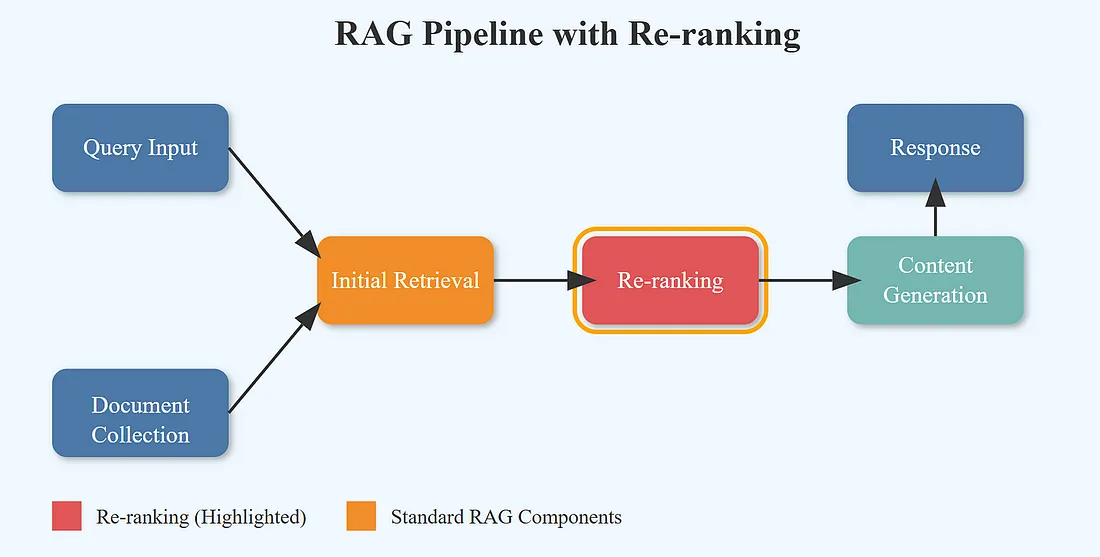



# Why do we need RE-RANKERS

- In Retrieval Augmented Generation (RAG), vector search is used for speed, but it compresses text meaning into vectors, causing information loss. This can lead to relevant information being ranked lower than less relevant results. Simply increasing the number of retrieved documents (top_k) is a basic solution to capture this lost information for improved LLM responses.
- Vector search in RAG can miss relevant information, which is often found lower in the results.
- Increasing the number of retrieved documents to compensate is problematic because LLMs have context window limits.
- "Context stuffing" (filling the context window) reduces the LLM's ability to recall information from the provided text.
- Vector search: Grabs a large pile of potentially relevant stuff quickly.
- Reranker: Sorts through that pile to find the very best stuff.
- LLM: Gets only the very best stuff to work with, so it can give you a great answer.
- rerankers are much more accurate than embedding models.

<div style="width: 100%; overflow-x: auto;">
  <img src="

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F906c3c0f8fe637840f134dbf966839ef89ac7242-3443x1641.png&w=3840&q=75" style="background-color: white;"/>


# Types of rerankers
- Primarily, there are 3 types of rerankers:

- BERT-based: These rerankers utilize the BERT model to rerank embeddings. BERT’s bidirectional nature allows for a deep contextual understanding of the text, improving the relevance of search results by considering the context of both the query and the document.

- BERT-based: It reads the search query and results together, deeply understanding context. This leads to very accurate results by knowing how all the words relate.

- Cross-Encoder: Cross-encoders handle the document and query together, encoding them simultaneously. This method allows for a more integrated and nuanced understanding of their relationship, which can significantly enhance the precision of relevance scoring. The joint encoding process enables the model to directly learn and evaluate the interactions between the query and document, providing a high level of accuracy in reranking.

- Cross-Encoder: This method looks at the query and result at the same time for detailed matching. It's highly precise, but takes more processing time.

- Bi-Encoder: Bi-encoders handle the document and query separately, making them more suitable for large datasets and real-time applications. They independently generate embeddings for the query and document, which are then compared using a similarity metric such as cosine similarity. This approach allows for efficient retrieval and scalability.

- Bi-Encoder: It processes the query and results separately, then compares them for similarity. This is faster and better for handling large amounts of data.


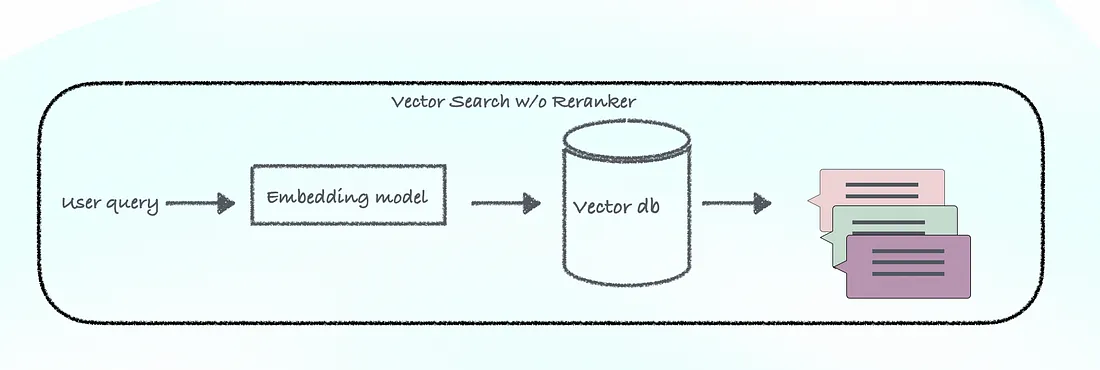

# Packages Installed
- pip install rerankers #Core package only, will require other dependencies already installed
- pip install "rerankers[transformers]" ###### All transformers-based approaches (cross-encoders, t5, colbert)
- pip install "rerankers[gpt]" ##### RankGPT
- pip install "rerankers[api]" ##### API-based rerankers (Cohere, Jina, MixedBread, Pinecone)
- pip install "rerankers[flashrank]" ##### FlashRank rerankers (ONNX-optimised, very fast on CPU)
- pip install "rerankers[rankllm]" ##### RankLLM rerankers (better RankGPT + support for local models such as RankZephyr and RankVicuna)
- pip install langchain_huggingface
- pip install langchain_community langchain_huggingface langchain_text_splitters
- pip install faiss-cpu
- pip install --upgrade --quiet  flashrank
- pip install --upgrade --quiet  faiss
- pip install langchain_openai
- %pip install --upgrade --quiet  rank_llm
- %pip install --upgrade --quiet  langchain_openai



### In the context of natural language processing (NLP), particularly in tasks like information retrieval, question answering, and semantic search, cross-encoders and bi-encoders refer to two different approaches to encoding pairs of inputs (like a query and a document) for comparison or ranking. Here's an overview of each:


| Feature         | Cross-Encoder                     | Bi-Encoder                        |
|-----------------|------------------------------------|-----------------------------------|
| **Input**       | Processes query and document together | Processes query and document independently |
| **Encoding**    | Joint encoding in a single pass    | Separate encodings for each input |
| **Efficiency**  | Computationally expensive (slow)   | More efficient (faster, scalable)  |
| **Accuracy**    | Often more accurate (captures interactions well) | May lose fine-grained interaction information |
| **Use case**    | Best for small datasets or tasks where accuracy is more important than speed | Best for large-scale or real-time systems where speed is critical |


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

HF_TOKEN =os.getenv('HF_TOKEN') 

os.environ['HF_TOKEN']=HF_TOKEN


In [3]:
from rerankers import Reranker

# Cross-encoder default. You can specify a 'lang' parameter to load a multilingual version!
#default this will be loaded mixedbread-ai/mxbai-rerank-base-v1
help(Reranker)


d:\PROJECT_PRACTISE_DIRS\GenAI\venv1\Lib\site-packages\pydantic\_internal\_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)



Help on function Reranker in module rerankers.reranker:

Reranker(model_name: str, lang: str = 'en', model_type: Optional[str] = None, verbose: int = 1, **kwargs) -> Optional[rerankers.models.ranker.BaseRanker]



In [4]:
ranker = Reranker('cross-encoder')
#ranker = Reranker('mixedbread-ai/mxbai-rerank-large-v1', model_type='cross-encoder')



Loading default cross-encoder model for language en
If your model is NOT intended to be ran as a one-label cross-encoder, please reload it and specify the model_type! Otherwise, you may ignore this warning. You may specify `model_type='cross-encoder'` to suppress this warning in the future.
Default Model: mixedbread-ai/mxbai-rerank-base-v1
Loading TransformerRanker model mixedbread-ai/mxbai-rerank-base-v1 (this message can be suppressed by setting verbose=0)
No device set
Using device cpu
No dtype set
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-base-v1
Using device cpu.
Using dtype torch.float32.


# CrossEncoderReranker

In [45]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
from nltk.tokenize import sent_tokenize
from langchain.docstore.document import Document


loader = TextLoader("state_of_the_union.txt", encoding="utf-8")

corpus = loader.load()

documents = [Document(page_content=sentence) for sentence in corpus[0].page_content.split("\n")]


embeddingsModel = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
retriever = FAISS.from_documents(documents, embeddingsModel).as_retriever(
    search_kwargs={"k": 1}
)

questions = {
'Q1': 'Which country, known for its vast population, boasts the world’s largest democratic system, with a population exceeding 1.4 billion?',
'Q2': 'Which country’s iconic landmark, a gift from France in 1886, stands proudly in a harbor as a symbol of freedom and hope for immigrants?',
'Q3': 'Which world-renowned monument, built by a Mughal emperor, stands in India as a testament to eternal love and is also a UNESCO World Heritage site?',
'Q4': 'Which ancient practice, originating in a country known for its spiritual traditions, is now widely embraced globally for its physical and mental benefits?',
'Q5': 'Which physical fitness system, created by a German-born innovator, focuses on core strength, flexibility, and postural alignment and is now widely practiced around the world?',
'Q6': 'Which rapidly developing Indian city, known for its tech and startup culture, has often been compared to a famous American innovation hub?',
'Q7': 'In which American state can you find a globally influential region that hosts companies like Apple and Google, marking the birthplace of numerous tech breakthroughs?',
'Q8': 'Which film industry, known for producing over 1,500 films annually, is recognized for its colorful storytelling and musical sequences, making it one of the largest in the world?',
'Q9': 'Which global film industry, based in a city known for its glamorous image, influences movies worldwide and produces films that generate billions in revenue each year?',
'Q10': 'Which river, flowing through the northern part of a large South Asian country, holds spiritual significance and serves as a site for rituals and pilgrimage?',
'Q11': 'Which major river, known for its historical significance in the expansion of a powerful nation, runs through the United States and is critical for trade and agriculture?',
'Q12': 'Which country is known for celebrating a myriad of colorful festivals like Diwali, Holi, and Eid, where each celebration holds deep cultural and religious meaning?',
'Q13': 'Which country’s national holidays include significant events such as Thanksgiving and Independence Day, each celebrated with family gatherings and festive meals?',
'Q14': 'Which country’s extensive rail system, operated by a national carrier named Amtrak, connects vast cities and regions across its territory?',
'Q15': 'Which country is home to one of the largest rail networks in the world, with millions of passengers transported daily across its vast subcontinent?',
'Q16': 'Which country’s culinary scene is diverse, with iconic dishes like hamburgers, hot dogs, and regional specialties such as New England clam chowder?',
'Q17': 'Which country’s cuisine is renowned for its bold and aromatic use of spices, featuring dishes like curry, dosa, and biryani that are enjoyed worldwide?',
'Q18': 'Which private aerospace company, founded by an entrepreneur with an ambitious goal of making space travel accessible, developed the first reusable rocket?',
'Q19': 'Which Asian space program, through the efforts of its national space agency, achieved a historic milestone by sending a mission to Mars with great success?',
'Q20': 'Which country, widely regarded as a pioneer in space exploration, is home to a private space company that made groundbreaking advances in rocket technology?',
}

answers = {
'Q1': 'India',
'Q2': 'America',
'Q3': 'India',
'Q4': 'India',
'Q5': 'America',
'Q6': 'Bengaluru',
'Q7': 'America',
'Q8': 'India',
'Q9': 'America',
'Q10': 'The Ganges River',
'Q11': 'The Mississippi River',
'Q12': 'India',
'Q13': 'America',
'Q14': 'America',
'Q15': 'India',
'Q16': 'America',
'Q17': 'India',
'Q18': 'America',
'Q19': 'India',
'Q20': 'America',
}

hit_rate_without_reranker = 0
import time 
start_time = time.time()
for qno,question in questions.items():
    docs = retriever.invoke(question)
    for doc in docs:
        if answers[qno].lower() in doc.page_content.lower():
            hit_rate_without_reranker += 1
print('Hit Rate For Using Hugging Face Embeddings',hit_rate_without_reranker) 
end_time = time.time()-start_time
print('Time Taken',end_time) 




2025-03-31 10:39:19,647 - INFO - Use pytorch device_name: cpu
2025-03-31 10:39:19,649 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Hit Rate For Using Hugging Face Embeddings 16
Time Taken 0.5621771812438965


In [30]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="mixedbread-ai/mxbai-rerank-base-v1")
compressor = CrossEncoderReranker(model=model, top_n=1)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

hit_rate_without_cross_encoder_reranker = 0
import time 
start_time = time.time()
for qno,question in questions.items():
    docs = retriever.invoke(question)
    for doc in docs:
        if answers[qno].lower() in doc.page_content.lower():
            hit_rate_without_cross_encoder_reranker += 1
print('Hit Rate For Using CrossEncoderReranker ',hit_rate_without_cross_encoder_reranker) 
end_time = time.time()-start_time
print('Time Taken',end_time) 

2025-03-31 09:52:32,724 - INFO - Use pytorch device: cpu


Hit Rate For Using CrossEncoderReranker  16
Time Taken 0.4941537380218506


# Evaluation Metrics For CrossEncoderReranker
- Hit Rate is the fraction of queries for which the correct answer is present in the top-k retrievals. For a given query, if we have a top 'k' value of 5, and if the correct answer is present in the first 5 retrieved documents, then the hit rate will be 1; otherwise, it will be 0.

- Mean Reciprocal Rank (MRR) is based on the rank of the highest-placed relevant document. For a given query, we will get the rank of the relevant document and then compute the inverse of the rank to get the query score. For example, if the relevant document is ranked 1, then the score for the given query is 1; if the relevant document is ranked 2, then the score is 0.5 (1/2).
- Maximum Marginal Relevance (MMR) re-ranks results to enhance both their relevance and diversity. In order to guarantee that the items returned are both relevant and sufficiently varied to address all facets of the query, MMR attempts to strike a balance between novelty and relevance.
- NDCG (Normalized Discounted Cumulative Gain):Measures the ranking quality by considering both the relevance of documents and their position in the ranked list. 
- MAP (Mean Average Precision):Calculates the average precision across all queries, providing an overall measure of the reranker's performance. 
- Precision at K:Measures the proportion of relevant documents within the top K results. 
- Recall at K:Measures the proportion of relevant documents retrieved within the top K results. 


# FlashrankRerank

In [31]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

compressor = FlashrankRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

hit_rate_with_flashrank_reranker = 0
import time 
start_time = time.time()
for qno,question in questions.items():
    docs = retriever.invoke(question)
    for doc in docs:
        if answers[qno].lower() in doc.page_content.lower():
            hit_rate_with_flashrank_reranker += 1
print('Hit Rate For Using FlashrankRerank ',hit_rate_with_flashrank_reranker) 
end_time = time.time()-start_time
print('Time Taken',end_time) 

Hit Rate For Using FlashrankRerank  16
Time Taken 0.5172061920166016


# RankLLM Reranker


In [32]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')

compressor = RankLLMRerank(top_n=1, model="gpt", gpt_model="gpt-4o-mini")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

hit_rate_with_rankllm_reranker = 0
import time 
start_time = time.time()
for qno,question in questions.items():
    docs = retriever.invoke(question)
    for doc in docs:
        if answers[qno].lower() in doc.page_content.lower():
            hit_rate_with_rankllm_reranker += 1
print('Hit Rate For Using RankLLMRerank ',hit_rate_with_rankllm_reranker) 
end_time = time.time()-start_time
print('Time Taken',end_time) 


Hit Rate For Using RankLLMRerank  16
Time Taken 0.664813756942749


In [ ]:
results = ranker.rank(query=query, docs=docs)
results.top_k(1)

In [46]:
hit_rate_with_rankllm_reranker = 0
ranker = Reranker('flashrank') # Defaults to MiniLM-L12-v2

import time 
start_time = time.time()
hit_rate__reranker = 0

for qno,question in questions.items():
    results = ranker.rank(query=question, docs=corpus[0].page_content.split("\n"))
    print(results.top_k(1))
end_time = time.time()-start_time
print('Time Taken',end_time) 


hit_rate__reranker = 0
import time 
start_time = time.time()
documents = corpus[0].page_content.split("\n")
for qno,question in questions.items():
    docs = ranker.rank(query=question, docs=documents)
    doc = results.top_k(1)
    if answers[qno].lower() in doc[0].document.text.lower():
        hit_rate__reranker += 1
print('Hit Rate For Using hit_rate__reranker ',hit_rate__reranker) 
end_time = time.time()-start_time
print('Time Taken',end_time) 


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
[Result(document=Document(text="India is home to the world's largest democracy, with over 1.4 billion people, representing a rich diversity of languages, cultures, and traditions.", doc_id=0, metadata={}, document_type='text', image_path=None, base64=None), score=0.99934465, rank=1)]
[Result(document=Document(text="The Statue of Liberty, located in New York Harbor, is a symbol of freedom and democracy, gifted to the United States by France in 1886. It stands as an iconic representation of America's welcoming spirit to immigrants and its commitment to liberty. The statue continues to inspire people around the world as a beacon of hope and opportunity.", doc_id=6, metadata={}, document_type='text', image_path=None, base64=None), score=0.999

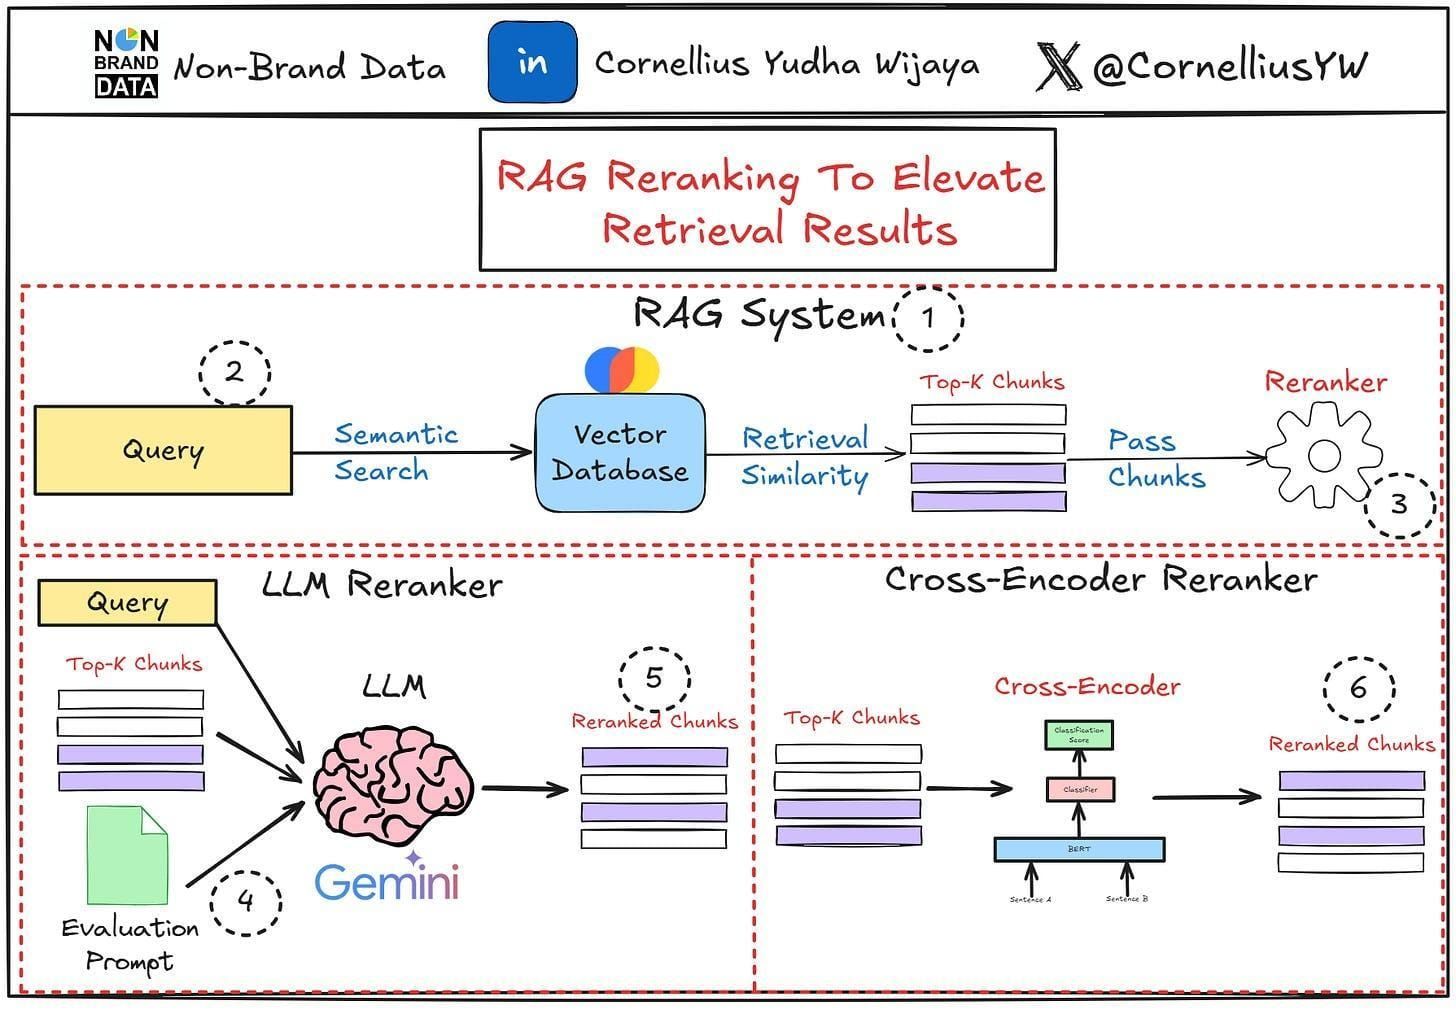

# References 
- https://medium.com/@sahin.samia/what-is-reranking-in-retrieval-augmented-generation-rag-ee3dd93540ee
- https://www.analyticsvidhya.com/blog/2024/05/rag-application-with-cohere-command-r-and-rerank/
- https://www.pinecone.io/learn/series/rag/rerankers/
- https://python.langchain.com/docs/integrations/document_transformers/cross_encoder_reranker/
- https://python.langchain.com/docs/integrations/retrievers/flashrank-reranker/
- https://docs.cohere.com/v2/docs/rerank-understanding-the-results#accuracy1-and-accuracy3
https://lancedb.github.io/lancedb/hybrid_search/eval/
https://akash-mathur.medium.com/advanced-rag-enhancing-retrieval-efficiency-through-evaluating-reranker-models-using-llamaindex-3f104f24607e
https://medium.com/@imabhi1216/basic-to-advanced-rag-using-llamaindex-optimizing-performance-with-rerankers-4-7e1131ff08f2